<a href="https://colab.research.google.com/github/thdnjs0730/2024-1-my-BDA/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D%EA%B3%BC%EC%A0%9C_03%EC%A1%B0_20231596_%EC%B5%9C%EC%86%8C%EC%9B%90_20231596_%EC%B5%9C%EC%86%8C%EC%9B%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 청소년 상담 접근성 향상
---

## 주제 선정 이유
1.   저출생과 고령화의 고속 진행
2.   청소년 우울감의 확대

## 문제 해결 목표

*   청소년은 미래의 사회, 경제적 리더가 될 집단
*   미래 사회의 중심, 청소년들의 정신 건강의 중요성
> **청소년 정신의 안정화는 중요한 일**

## 사용 데이터
###1. 청소년 우울감 경험률.csv
- 230530_보도자료_ 2023년 청소년 통계 발표_최종배포본.pdf
- 여성가족부 제공

###2. 유동인구.csv
- 230530_보도자료_ 2023년 청소년 통계 발표_최종배포본.pdf
- 서울교통공사 제공

###3. 거주인구.csv
- 202403_202403_주민등록 인구 기타현황(아동청소년청년 인구현황)_ChYouth.csv
- 행정안전부 제공

###4. SIG_Seoul.geojson
- https://github.com/youngwoos/Doit_Python

---
## 파이썬 설치 확인


In [1]:
import sys
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [2]:
import site
site.getsitepackages()

['/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.10/dist-packages']

In [3]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns

print(sys.version)
print(pd.__version__)
print(np.__version__)
print(sns.__version__)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
2.0.3
1.25.2
0.13.1


## 코랩에서 한글 처리

In [4]:
!pip  install koreanize_matplotlib

## 그래프 해상도 설정

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi':'100'})

In [6]:
# 해상도 선명하게
%config InlineBackend.figure_format = 'retina'

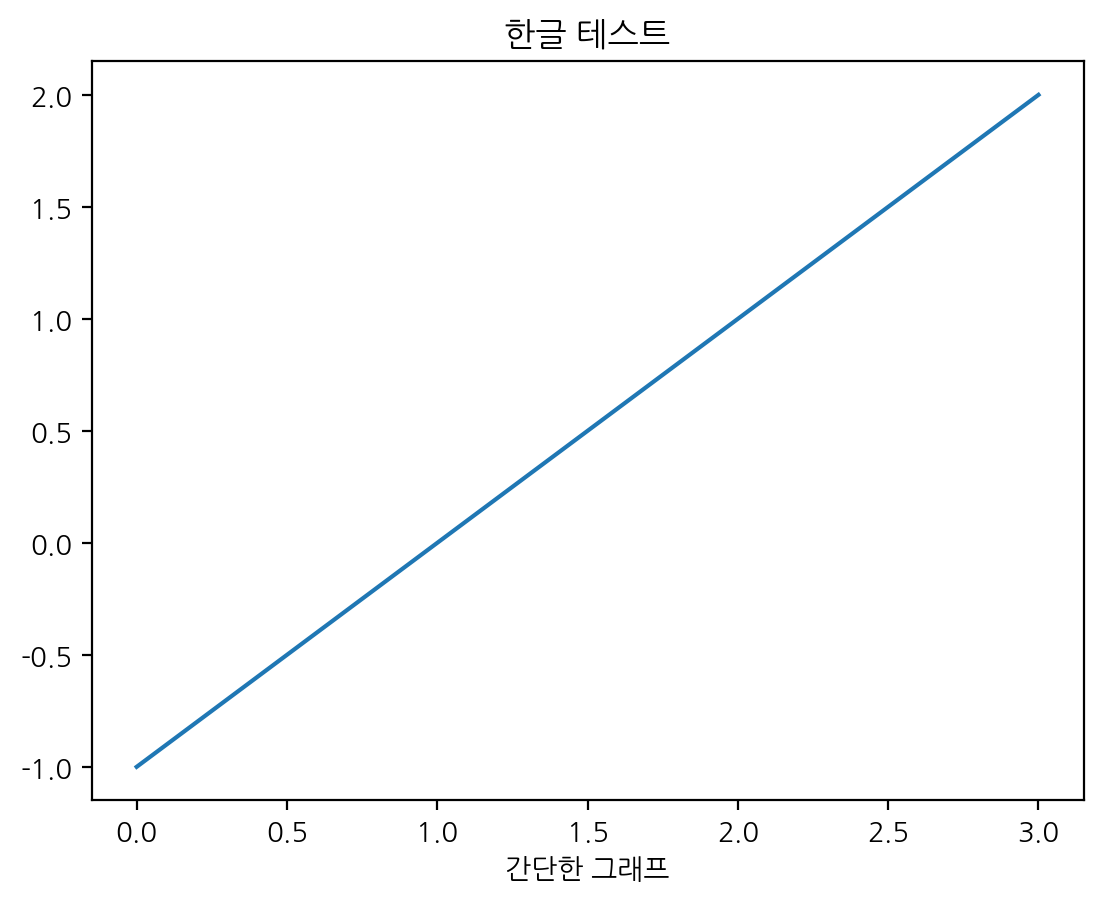

In [7]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot([-1, 0, 1, 2])
plt.title('한글 테스트')
plt.xlabel('간단한 그래프')
plt.show()

---
## 1. 청소년 우울감 예측





### 데이터 로드 및 전처리

In [8]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# 데이터 로드
dep_pre_df = pd.read_csv('청소년 우울감 경험률.csv')

In [10]:
# 데이터 전처리: 중학생과 고등학생의 우울감 경험률 합산
dep_pre_df['총합'] = dep_pre_df['중학생'] + dep_pre_df['고등학생']

# 입력 변수(X)와 목표 변수(y) 설정
X = dep_pre_df[['연도']]
y = dep_pre_df['총합']

In [11]:
# 데이터 확인
print(dep_pre_df.head())

     연도   중학생  고등학생    총합
0  2011  30.0  35.5  65.5
1  2012  28.2  32.6  60.8
2  2013  29.0  32.6  61.6
3  2014  24.4  28.8  53.2
4  2015  21.2  25.6  46.8


### 모델 학습 및 예측

In [12]:
# SVR 모델 생성 및 학습
svr_model = SVR(kernel='rbf', C=11)  # 가우시안 RBF 커널 사용
svr_model.fit(X, y)

SVR(C=11)

In [13]:
# 2011년부터 2025년까지 예측
X_future = np.arange(2011, 2026).reshape(-1, 1)
y_pred = svr_model.predict(X_future)

# 2023년부터 2025년까지의 예측값 출력
future_predictions = {year: pred for year, pred in zip(range(2023, 2026), y_pred[-3:])}
for year, pred in future_predictions.items():
    print(f"{year}년 예측값: {pred:.2f}")

2023년 예측값: 57.98
2024년 예측값: 58.83
2025년 예측값: 58.95


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### 시각화

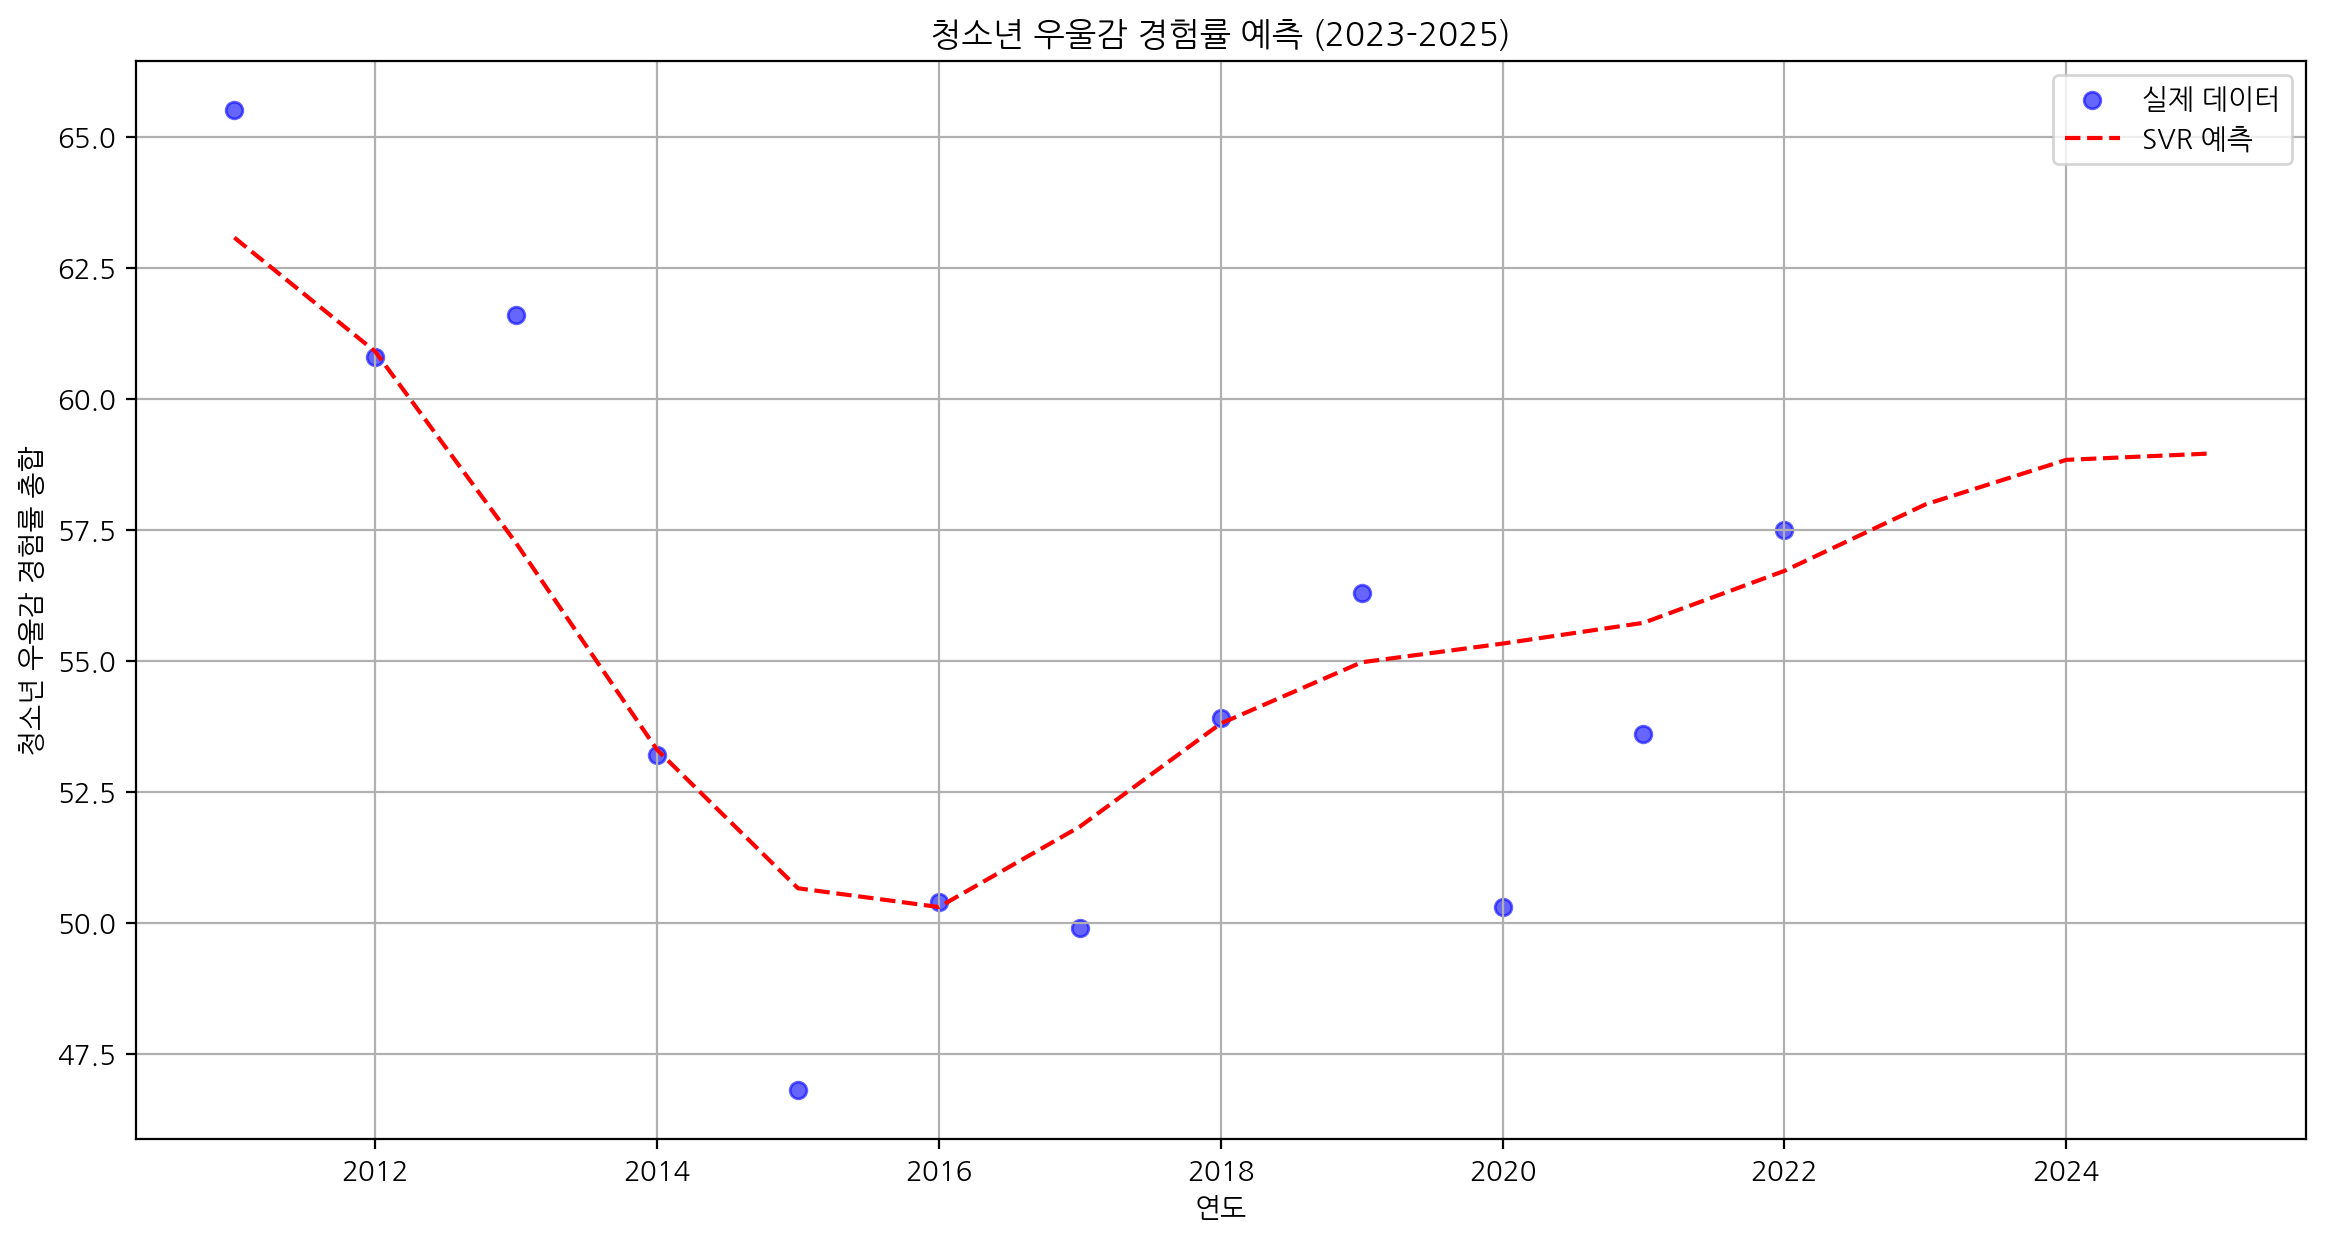

In [14]:
plt.figure(figsize=(14, 7))
plt.scatter(dep_pre_df['연도'], dep_pre_df['총합'], color='blue', label='실제 데이터', alpha=0.6)
plt.plot(X_future, y_pred, color='red', linestyle='--', label='SVR 예측')
plt.xlabel('연도')
plt.ylabel('청소년 우울감 경험률 총합')
plt.title('청소년 우울감 경험률 예측 (2023-2025)')
plt.legend()
plt.grid(True)
plt.show()

## 2. 청소년 이동 지역

### 데이터 로드 및 전처리

In [20]:
# 데이터 로드
move_df = pd.read_csv("유동인구.csv", encoding='cp949')

In [25]:
# 청소년 승객 필터링
is_teenager = move_df['승객유형'] == '청소년'
teenager = move_df[is_teenager]

### 최대 승차 및 하차 역 찾기

In [26]:
# 최대 승차 및 하차 인원과 시간을 저장 리스트 초기화
mx_on = [0] * 20
mx_off = [0] * 20
mx_station = [''] * 20
mx_station_on = [''] * 20
mx_station_off = [''] * 20
mx_time = [0] * 20

In [27]:
# 각 시간대별 최대 승차 및 하차 인원과 역 찾기
for row in teenager.itertuples(index=False):
    for i in range(20):
        temp = row[i + 7]  # 시간대별 승차/하차 인원
        if row[5] == '승차':  # 승차일 경우
            if temp > mx_on[i]:  # 최대 승차 인원을 갱신할 경우
                mx_on[i] = temp
                t = (i + 6) % 24
                if t == 0:
                    t = 24
                mx_time[i] = t  # 시간대 저장
                mx_station_on[i] = row[4]  # 역 이름 저장
        elif row[5] == '하차':  # 하차일 경우
            if temp > mx_off[i]:  # 최대 하차 인원을 갱신할 경우
                mx_off[i] = temp
                t = (i + 6) % 24
                if t == 0:
                    t = 24
                mx_time[i] = t  # 시간대 저장
                mx_station_off[i] = row[4]  # 역 이름 저장

        # 승차 및 하차 역 정보를 통합하여 저장
        mx_station[i] = f'승차: {mx_station_on[i]}\n하차: {mx_station_off[i]} ({mx_time[i]}시)'

### 시각화

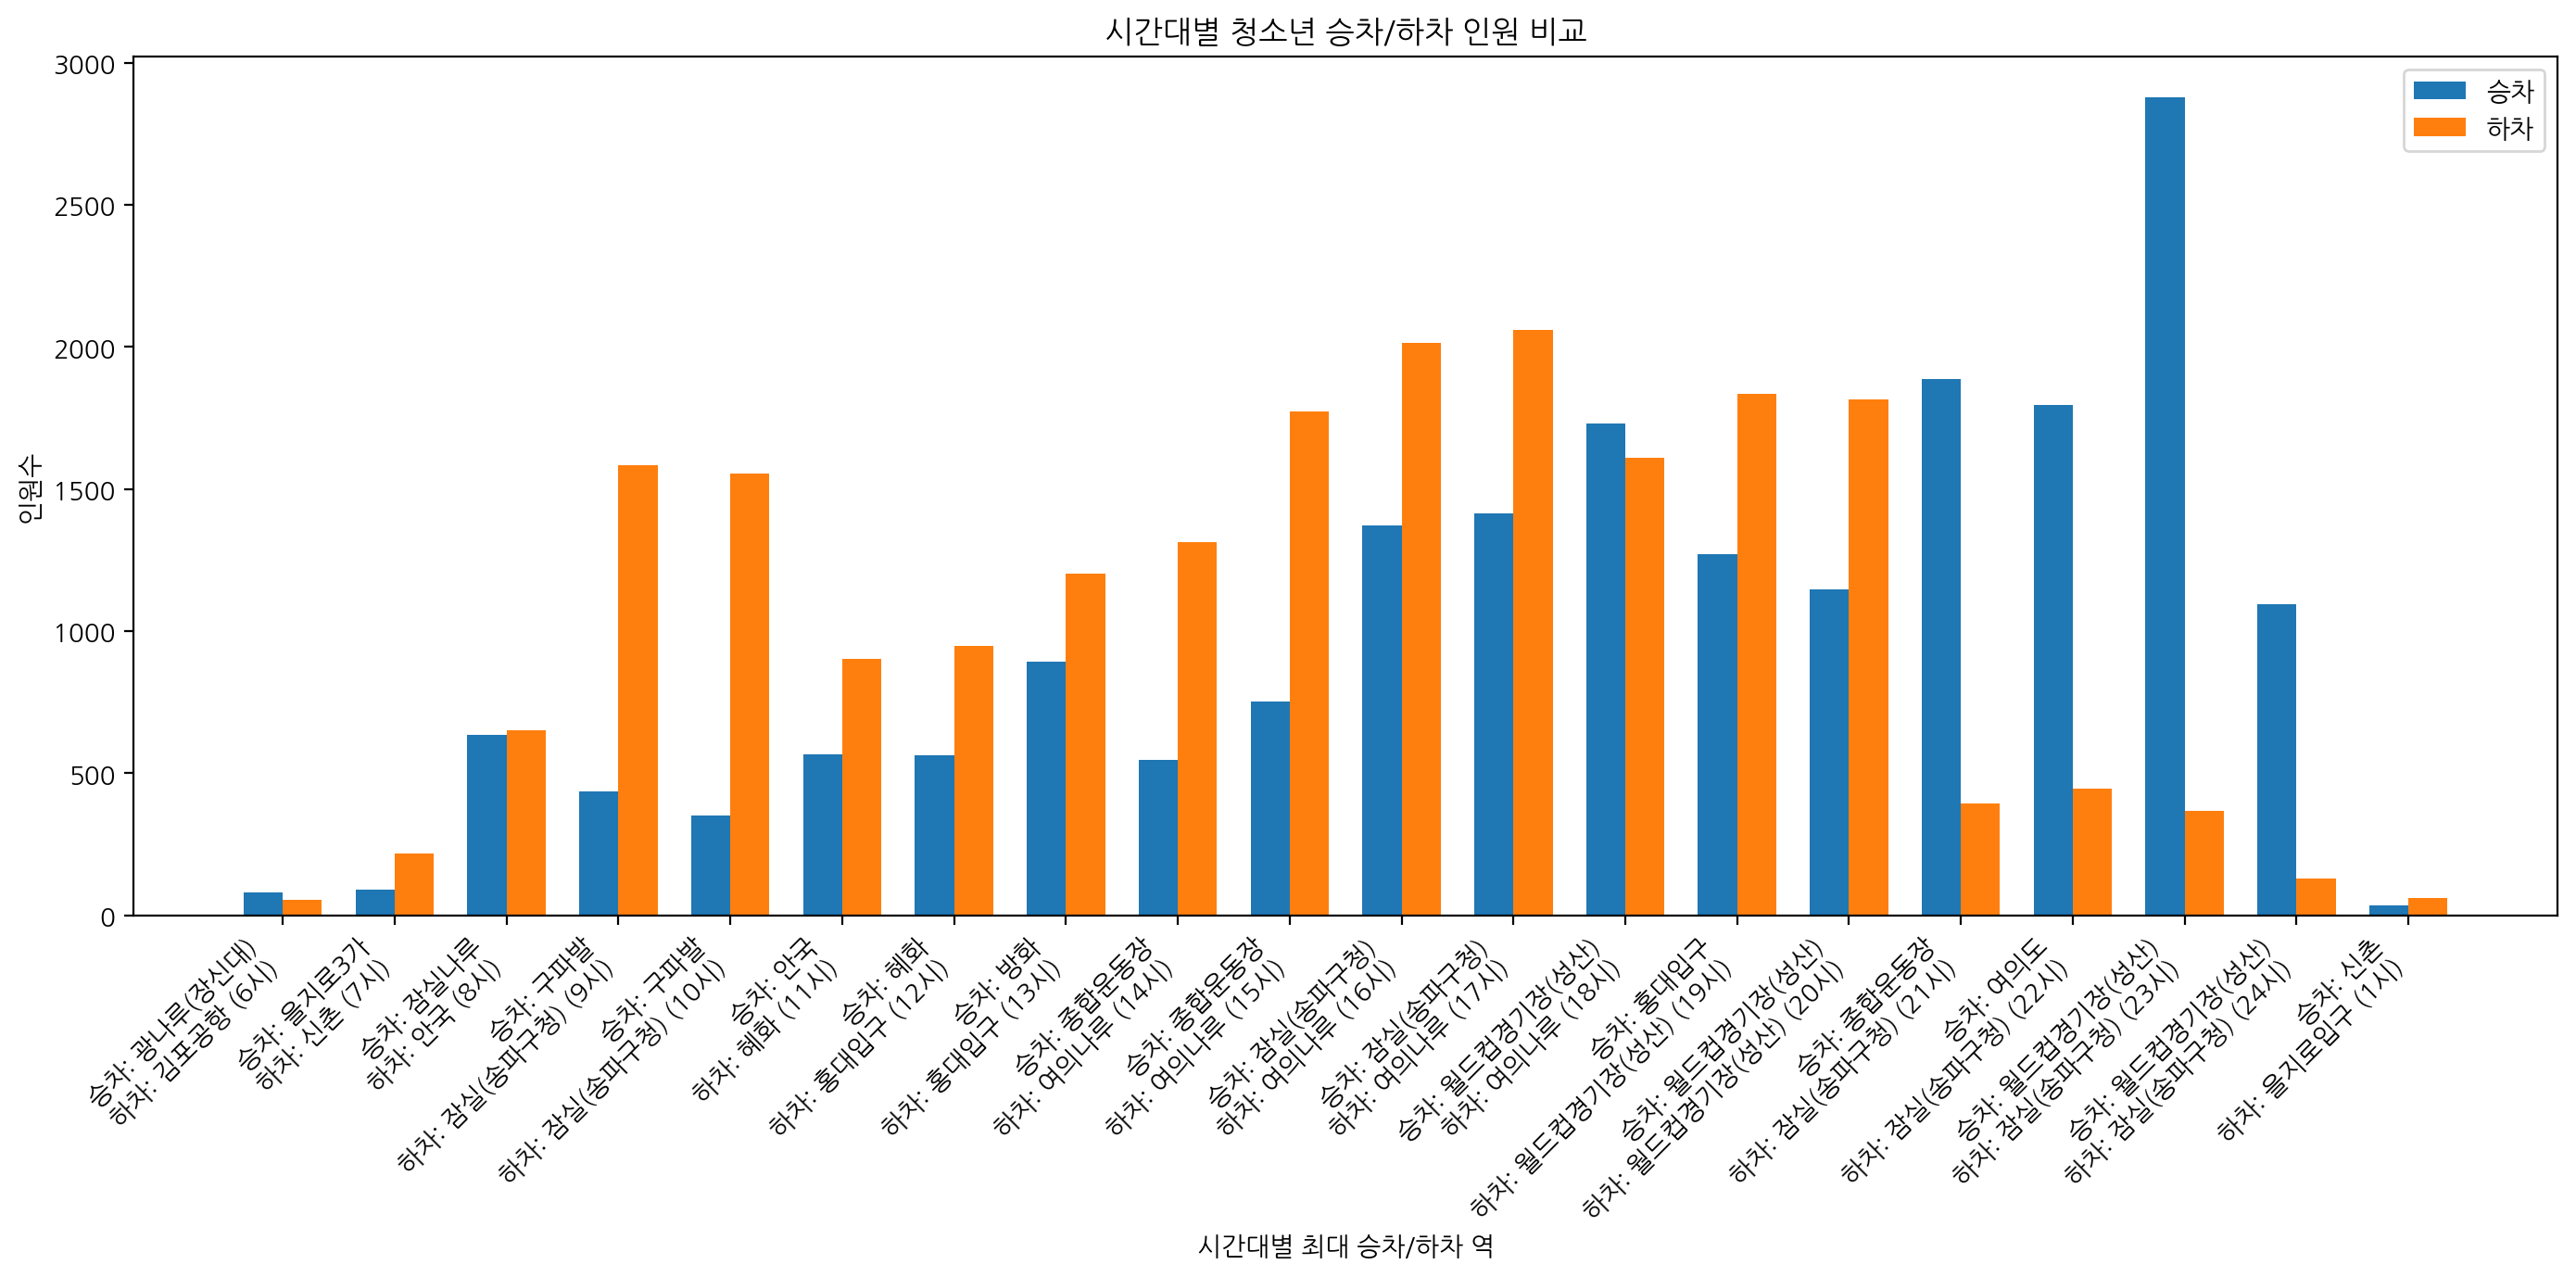

In [28]:
fig, axx = plt.subplots(figsize=(14, 7))
bar_width = 0.35
index = np.arange(20)

# 최대 승차 및 하차 인원을 바 차트로 그리기
plt.bar(index, mx_on, bar_width, label='승차')
plt.bar(index + bar_width, mx_off, bar_width, label='하차')

# x축 라벨 설정
plt.xlabel('시간대별 최대 승차/하차 역')
plt.ylabel('인원수')
plt.title('시간대별 청소년 승차/하차 인원 비교')
plt.xticks(index + bar_width / 2, mx_station, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## 3. 청소년 거주 지역

### 데이터 로드 및 전처리

In [29]:
import geopandas as gpd

In [30]:
# 서울 행정구역 GeoJSON 파일 불러오기
gdf_seoul = gpd.read_file('SIG_Seoul.geojson')

# 주민등록 인구 데이터 불러오기
df_pop = pd.read_csv('거주인구.csv', skiprows=2)

In [31]:
# "청소년 전체" 열의 데이터를 숫자형으로 변환
df_pop['청소년 전체'] = df_pop['청소년 전체'].str.replace(',', '').astype(int)

# '행정기관코드' 열의 데이터를 문자열로 변환하고 슬라이싱
df_pop['행정기관코드'] = df_pop['행정기관코드'].astype(str).str[:5]

In [32]:
# 데이터 확인
print(df_pop.head())

  행정기관코드              행정기관       전체       남자       여자    아동전체    아동남자    아동여자  \
0  11110  서울특별시 서울특별시 종로구   139,498   67,228   72,270  13,298   6,619   6,679   
1  11140   서울특별시 서울특별시 중구   121,602   58,767   62,835  10,220   5,189   5,031   
2  11170  서울특별시 서울특별시 용산구   209,849  100,488  109,361  21,195  10,844  10,351   
3  11200  서울특별시 서울특별시 성동구   276,964  134,232  142,732  30,131  15,300  14,831   
4  11215  서울특별시 서울특별시 광진구   335,105  160,888  174,217  33,322  16,968  16,354   

   청소년 전체   청소년남자   청소년여자    청년전체    청년남자    청년여자  
0   19718   9,296  10,422  33,815  16,330  17,485  
1   13415   6,412   7,003  30,028  14,121  15,907  
2   26090  12,518  13,572  51,569  24,352  27,217  
3   36886  17,919  18,967  67,131  32,540  34,591  
4   48615  23,419  25,196  93,127  44,361  48,766  


In [33]:
# GeoDataFrame과 인구 데이터를 병합
gdf_seoul = gdf_seoul.merge(df_pop, how='left', left_on='SIG_CD', right_on='행정기관코드')

### 지도 시각화

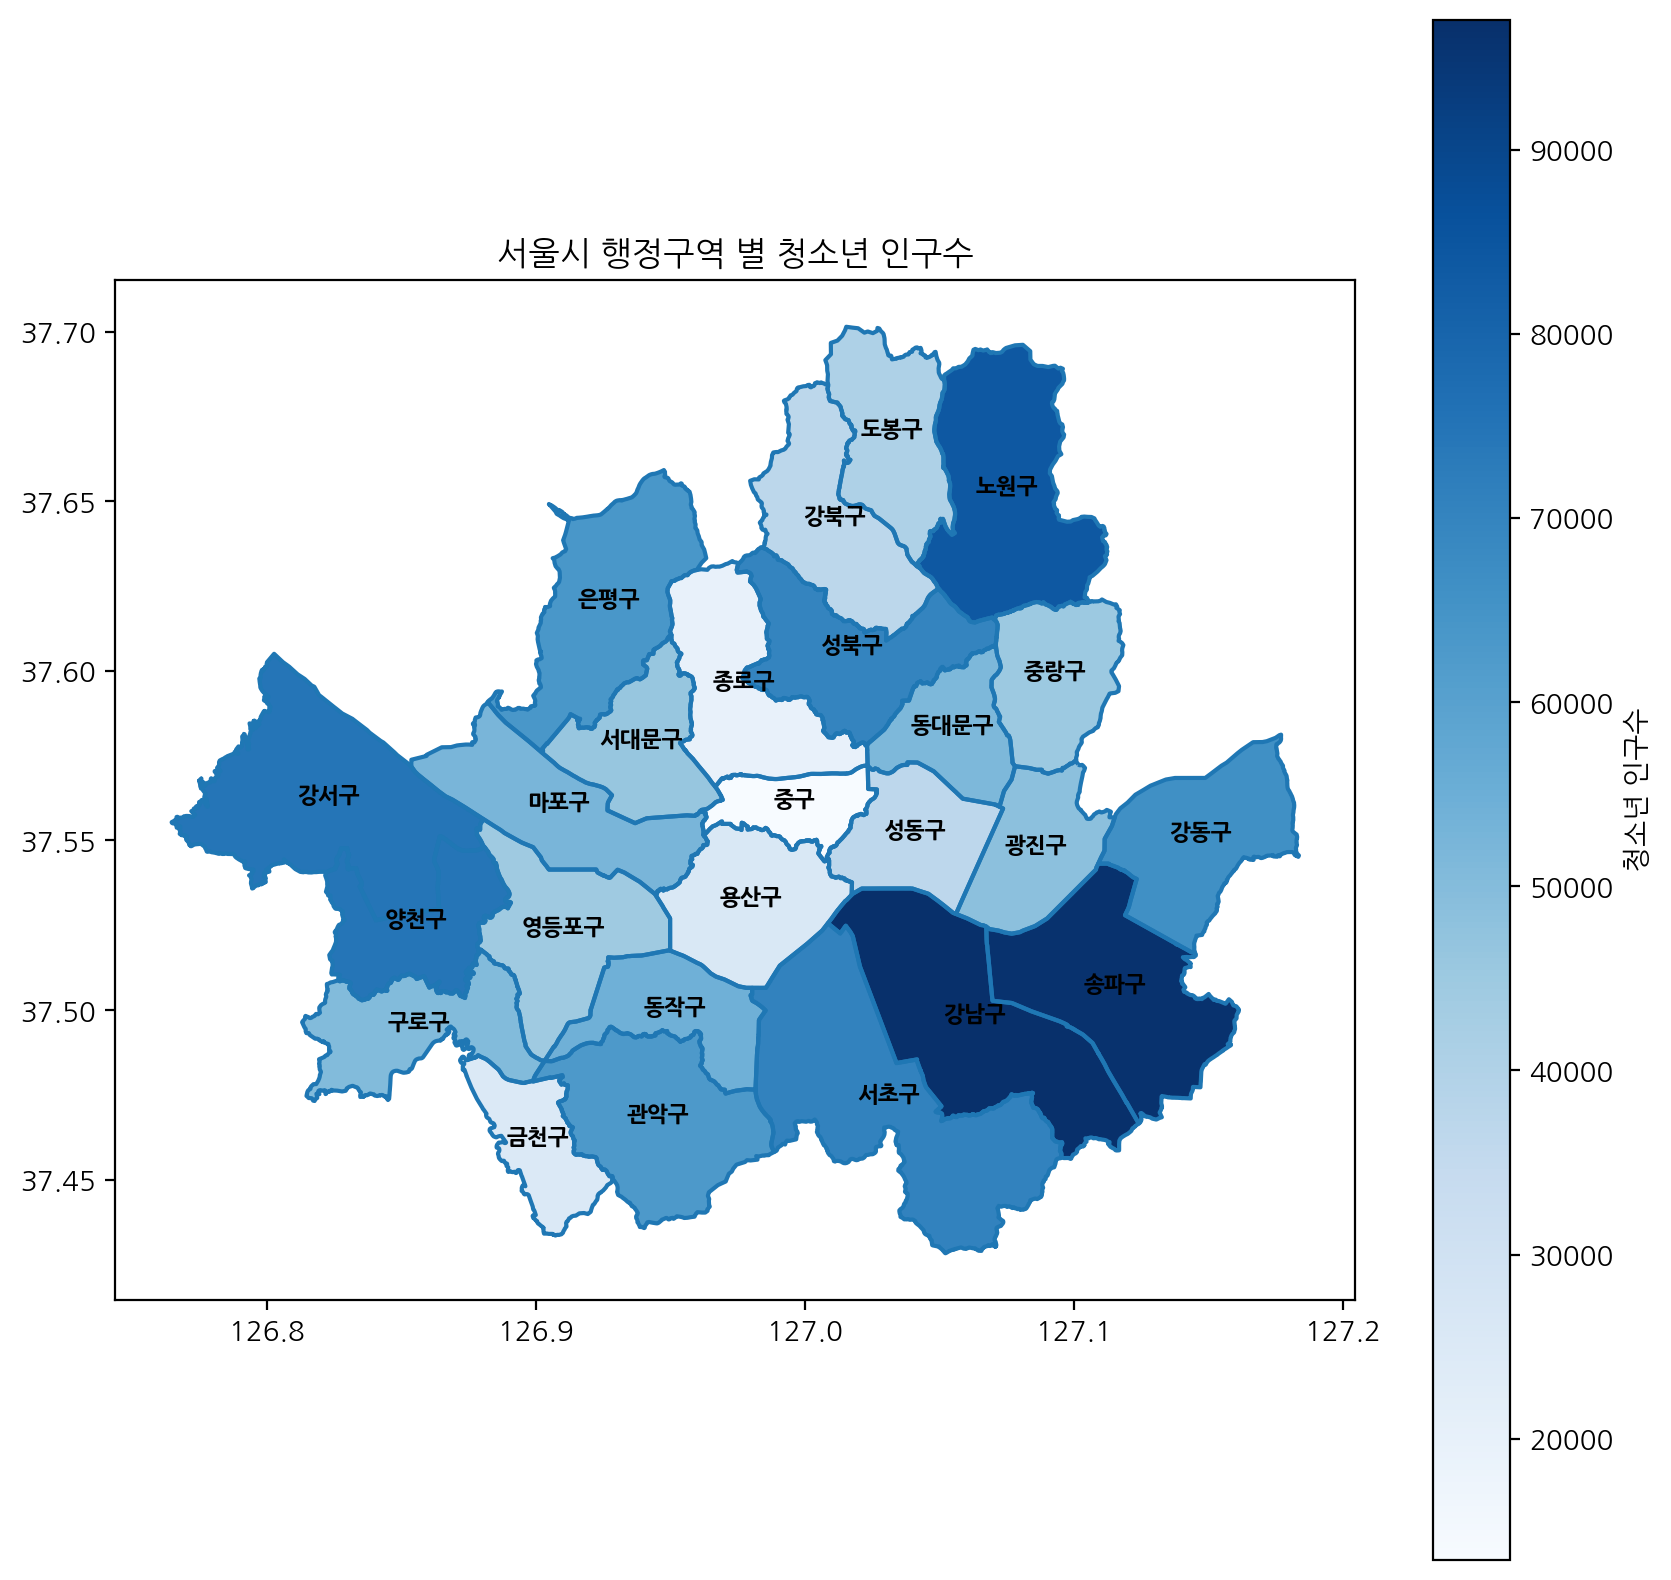

In [34]:
# 지도 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_seoul.boundary.plot(ax=ax)
gdf_seoul.plot(column='청소년 전체', ax=ax, legend=True, cmap='Blues', legend_kwds={'label': "청소년 인구수"})
plt.title("서울시 행정구역 별 청소년 인구수")

# 지역 이름 추가
for idx, row in gdf_seoul.iterrows():
    plt.annotate(text=row['SIG_KOR_NM'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=8, color='black', weight='bold')

plt.show()